In [1]:
# Copia do estudo por hora, mas somando os dias
import pandas as pd
import matplotlib.pyplot as plt


import os

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [2]:
dataset_file_path = "/home/joao/Documents/repos/renewable-generation-into-reserve-markets/data/DynamicSecondary.csv"

In [3]:
dataset = pd.read_csv(dataset_file_path, index_col=0)

In [4]:
dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   
35062           NaN         NaN                      NaN             NaN   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   
35062                  NaN               NaN                   NaN   

       DA Traded Wind  DA Traded PV  
0              4326.8           7.1  
1              4213.9           7.1  
2              4059.7           7.1  
3              3921.6           7.1  
4              3902.3          14.1  
...               ...           ...  
35058         11457.4           8.6  
35059          9346.3           7.2  
35060          9190.6           6.7  
35061          8314.2           6.6  
35062          6612.5           2.0  

[35063 rows x 9 columns]

In [5]:
# Simply remove NAN 
dataset = dataset.dropna(how='any')



/home/joao/.virtualenvs/tese/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


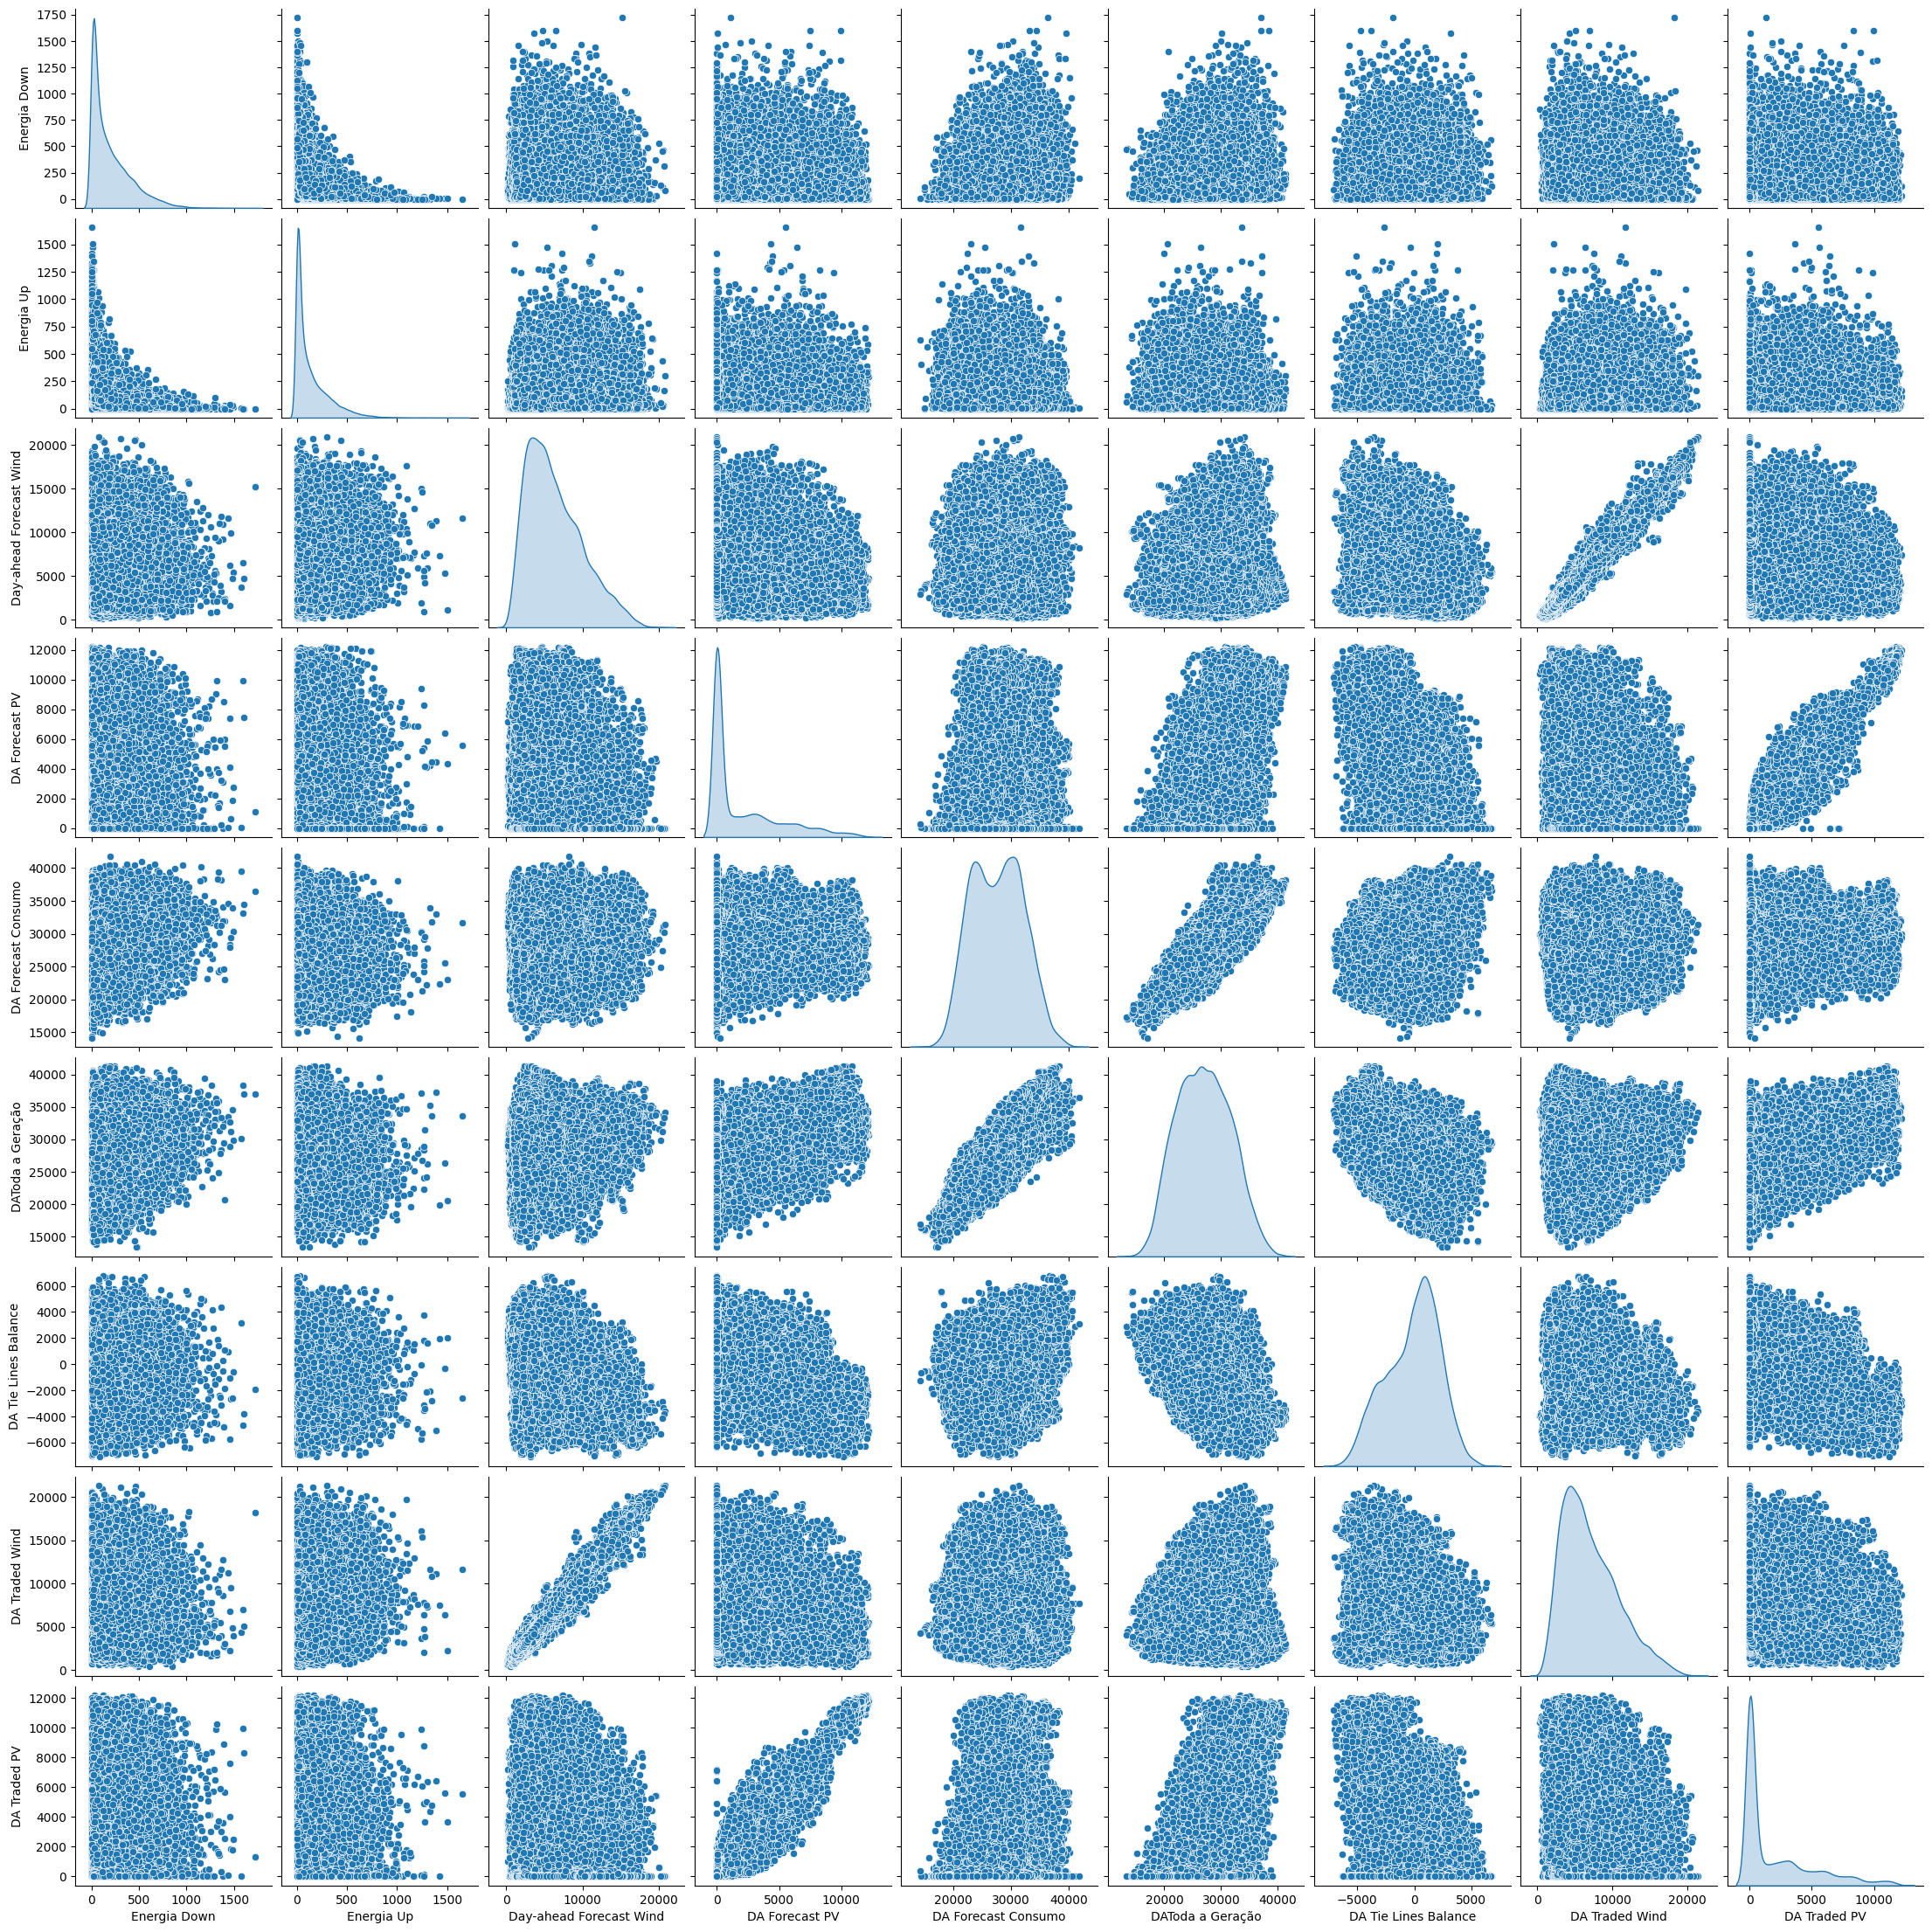

In [6]:
import seaborn as sns

columns_Y = ["Energia Down", "Energia Up"]
columns_X = dataset.columns[~dataset.columns.isin(columns_Y)] 
sns.pairplot(dataset, diag_kind='kde')


In [7]:
dataset.describe().transpose()


count          mean          std      min  \
Energia Down             35062.0    199.737111   212.105286      0.0   
Energia Up               35062.0    137.395391   170.934599      0.0   
Day-ahead Forecast Wind  35062.0   6374.223966  3649.760395    139.0   
DA Forecast PV           35062.0   2051.058096  2892.850361      0.0   
DA Forecast Consumo      35062.0  27604.713342  4476.201061  14170.0   
DAToda a Geração         35062.0  26962.275891  4733.416102  13340.4   
DA Tie Lines Balance     35062.0   -152.077925  2339.477426  -7112.5   
DA Traded Wind           35062.0   7091.271020  3719.988346    392.8   
DA Traded PV             35062.0   2084.573997  2905.386228      0.1   

                               25%         50%        75%      max  
Energia Down                31.700    127.0000    306.700   1721.4  
Energia Up                  11.200     67.6000    206.700   1654.8  
Day-ahead Forecast Wind   3489.475   5664.1500   8710.500  20879.3  
DA Forecast PV               0.000    133.8875   3504.200  12203.1  
DA Forecast Consumo      23953.250  27632.0000  31028.750  41773.0  
DAToda a Geração         23323.150  26854.2500  30477.125  41299.4  
DA Tie Lines Balance     -1839.275    171.7500   1558.150   6769.5  
DA Traded Wind            4192.525   6339.4500   9428.325  21330.8  
DA Traded PV                 8.300    250.7000   3460.950  12175.5

In [8]:
## Queremos prever as colunas "Energia Down" e "Energia Up" 
## Logo temos de criar um gerador que de os dados


# Create a generator for the timeseries with a moving window.

from tensorflow import keras
import math

#1461 -> 1 day

one_day = 1461

class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        dataset,
        time_moving_window_size_X=168, #batch size 7 days, 168 hours,
        time_moving_window_size_Y=24, #to predict the after 1 day, 24 hours,
        y_columns = ["Energia Down", "Energia Up"],
        keep_y_on_x=False,
    ):
        self.y_columns = y_columns
        self.y = dataset[self.y_columns].to_numpy()
        if not keep_y_on_x:
            self.x = dataset.loc[:, ~dataset.columns.isin(self.y_columns)].to_numpy()
        else:
            self.x = dataset.to_numpy()
            
        self.x_batch = time_moving_window_size_X
        self.y_batch = time_moving_window_size_Y
        
        self.dataset_size = len(dataset)
        
    def __len__(self):
        # The return value is the actual generator size, the number of times it
        # can be called.
        
        return self.dataset_size - sum([self.x_batch,self.y_batch])

    def __getitem__(self, index):
        
        limit_point = index+self.x_batch
        
        X = self.x[index:limit_point]
        Y = self.y[limit_point:limit_point+self.y_batch]
        
        return X, Y, index

        


2023-07-19 13:05:06.245862: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 13:05:06.278991: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 13:05:06.279796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 13:05:06.891320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
import numpy as np
import math




def get_dataset(dataset,  time_moving_window_size_X=168, #batch size 7 days, 168 hours,
        time_moving_window_size_Y=24, #to predict the after 1 day, 24 hours,
        y_columns = ["Energia Down", "Energia Up"],
        keep_y_on_x=False,
                frac=0.8,
                index_train=[],
):
    gen = DataGenerator(dataset, time_moving_window_size_X, time_moving_window_size_Y, y_columns, keep_y_on_x)


    X, Y, ind = [], [], []

    for x, y,i in gen:
        X.append(x)
        Y.append(y)
        ind.append(i)
    X = np.array(X)
    Y = np.array(Y)


    train_len = math.ceil(frac * len(X))
    test_len = len(X) - train_len

#     index_dataset = np.arange(len(X))
#     if len(index_train)==0:
#         index_train = np.random.choice(index_dataset, train_len, replace=False)
#         index_train = np.sort(index_train)
#     print(len(index_train))
#     print(train_len)

#     if len(index_train)!=train_len:
#         index_train = np.sort(index_train)[:train_len]
#     print(len(index_train))

#     index_test = np.setdiff1d(index_dataset, index_train)
    
    
    train_dataset_X = X[:train_len]
    test_dataset_X = X[train_len:train_len+test_len]


    train_dataset_Y = Y[:train_len]
    test_dataset_Y = Y[train_len:train_len+test_len]
    
    test_index = ind[train_len:train_len+test_len]
    
    
    return train_dataset_X, train_dataset_Y, test_dataset_X, test_dataset_Y, np.array(test_index)

In [10]:

frac = 0.8

train_len = math.ceil(frac * len(dataset))
test_len = len(dataset) - train_len


index_dataset = np.arange(len(dataset))

index_train = np.random.choice(index_dataset, train_len, replace=False)
index_train = np.sort(index_train)
index_test = np.setdiff1d(index_dataset, index_train)

In [11]:
test_dataset = dataset.copy()

In [12]:
# train_features = train_dataset.copy()
# test_features = test_dataset.copy()



# train_labels = train_features.drop(columns_Y, axis=1)
# test_labels = test_features.drop(columns_Y, axis=1)


# Y = train_features[columns_Y]
# test_Y = test_features[columns_Y]


In [13]:
# train_dataset.describe().transpose()[['mean', 'std']]


In [14]:
# train_labels.shape

In [15]:
X_timeseries = 1
Y_timeseries = 1

train_dataset_X, train_dataset_Y, test_dataset_X, test_dataset_Y,test_index = get_dataset(dataset, 
                                                                               time_moving_window_size_X=X_timeseries,
                                                                              time_moving_window_size_Y=Y_timeseries,
                                                                              index_train=index_train)

In [16]:

end_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[-1][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[-1][0][1])].index.item()
start_ind = test_dataset[(test_dataset["Energia Down"]==test_dataset_Y[0][0][0])&(test_dataset["Energia Up"]==test_dataset_Y[0][0][1])].index.item()

In [17]:
test_dataset.loc[start_ind:end_ind]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
28049         638.9         2.3                  15822.0            62.7   
28050         410.3         0.5                  15684.0             0.0   
28051         269.4        12.7                  15627.0             0.0   
28052         252.8        14.7                  15627.0             0.0   
28053         161.0        21.4                  15427.0             0.0   
...             ...         ...                      ...             ...   
35056         113.2       374.4                  10588.0             0.0   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
28049              31533.0           35048.3               -4162.2   
28050              32765.0           36029.4               -4060.0   
28051              31676.0           35060.3               -4080.5   
28052              28887.0           32296.1               -4217.2   
28053              26119.0           29388.5               -3884.8   
...                    ...               ...                   ...   
35056              25526.3           24829.1                -496.0   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   

       DA Traded Wind  DA Traded PV  
28049         17796.2         169.3  
28050         17852.7         161.4  
28051         17468.7         116.0  
28052         16997.5          37.9  
28053         16607.7           5.5  
...               ...           ...  
35056         11444.4         301.1  
35057         11529.9          58.5  
35058         11457.4           8.6  
35059          9346.3           7.2  
35060          9190.6           6.7  

[7012 rows x 9 columns]

In [18]:
from tensorflow.keras import backend as K


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (
    Normalization,
    Dense,Dropout

)
from keras.models import Model

input_layer = Input((7))
normed = Normalization()(input_layer)
output = Dense(2, activation="linear")(normed)

model_dense = Model(inputs=input_layer, outputs=output)


In [20]:
model_dense.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization (Normalizati  (None, 7)                 15        
 on)                                                             
                                                                 
 dense (Dense)               (None, 2)                 16        
                                                                 
Total params: 31 (128.00 Byte)
Trainable params: 16 (64.00 Byte)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________


In [21]:
model_dense.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)

In [22]:
model_dense.fit(train_dataset_X.squeeze(), train_dataset_Y.squeeze(), epochs=30)

Epoch 1/30
877/877 [==============================] - 1s 1ms/step - loss: 858.7932 - root_mean_squared_error: 858.5782
Epoch 2/30
877/877 [==============================] - 1s 1ms/step - loss: 422.2839 - root_mean_squared_error: 422.3009
Epoch 3/30
877/877 [==============================] - 1s 1ms/step - loss: 359.5587 - root_mean_squared_error: 359.4990
Epoch 4/30
877/877 [==============================] - 1s 889us/step - loss: 319.3106 - root_mean_squared_error: 319.2708
Epoch 5/30
877/877 [==============================] - 1s 904us/step - loss: 293.7077 - root_mean_squared_error: 293.7506
Epoch 6/30
877/877 [==============================] - 1s 920us/step - loss: 276.2095 - root_mean_squared_error: 276.1901
Epoch 7/30
877/877 [==============================] - 1s 886us/step - loss: 261.5302 - root_mean_squared_error: 261.5424
Epoch 8/30
877/877 [==============================] - 1s 874us/step - loss: 249.5444 - root_mean_squared_error: 249.5400
Epoch 9/30
877/877 [==================

In [23]:
predictions = model_dense.predict(test_dataset_X.squeeze())

220/220 [==============================] - 0s 769us/step


In [24]:
model_dense.history

In [25]:
model_dense.evaluate(test_dataset_X.squeeze(), test_dataset_Y.squeeze())

220/220 [==============================] - 0s 984us/step - loss: 200.4641 - root_mean_squared_error: 201.0538


[200.46408081054688, 201.05380249023438]

In [26]:
len(predictions)

7012

In [27]:
len(test_dataset_Y)

7012

In [28]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV  
0              4326.8           7.1  
1              4213.9           7.1  
2              4059.7           7.1  
3              3921.6           7.1  
4              3902.3          14.1  
...               ...           ...  
35057         11529.9          58.5  
35058         11457.4           8.6  
35059          9346.3           7.2  
35060          9190.6           6.7  
35061          8314.2           6.6  

[35062 rows x 9 columns]

In [29]:
test_dataset["dense Energia Down"] = None
test_dataset["dense Energia Up"] = None

test_dataset.loc[start_ind:end_ind, "dense Energia Down"] = predictions[:,0]
test_dataset.loc[start_ind:end_ind, "dense Energia Up"] = predictions[:,1]


In [30]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  
0              4326.8           7.1               None             None  
1              4213.9           7.1               None             None  
2              4059.7           7.1               None             None  
3              3921.6           7.1               None             None  
4              3902.3          14.1               None             None  
...               ...           ...                ...              ...  
35057         11529.9          58.5         152.996567       128.969223  
35058         11457.4           8.6         154.705734       131.108673  
35059          9346.3           7.2          145.27063       141.688629  
35060          9190.6           6.7         132.074951          95.9356  
35061          8314.2           6.6               None             None  

[35062 rows x 11 columns]

In [31]:

end_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[-1][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[-1][0][4])].index.item()
start_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[0][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[0][0][4])].index.item()

In [32]:
end_ind

35059

In [33]:
test_dataset[start_ind:end_ind+3]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
28048         354.0         1.4                  15913.0           489.9   
28049         638.9         2.3                  15822.0            62.7   
28050         410.3         0.5                  15684.0             0.0   
28051         269.4        12.7                  15627.0             0.0   
28052         252.8        14.7                  15627.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
28048              29419.0           33122.9               -4301.0   
28049              31533.0           35048.3               -4162.2   
28050              32765.0           36029.4               -4060.0   
28051              31676.0           35060.3               -4080.5   
28052              28887.0           32296.1               -4217.2   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  
28048         17796.6         773.1               None             None  
28049         17796.2         169.3         169.068665       224.169327  
28050         17852.7         161.4         189.304382       229.302521  
28051         17468.7         116.0         198.458633       229.816238  
28052         16997.5          37.9         192.185455       224.553116  
...               ...           ...                ...              ...  
35057         11529.9          58.5         152.996567       128.969223  
35058         11457.4           8.6         154.705734       131.108673  
35059          9346.3           7.2          145.27063       141.688629  
35060          9190.6           6.7         132.074951          95.9356  
35061          8314.2           6.6               None             None  

[7014 rows x 11 columns]

In [34]:
import h5py
uri = "model_dense.keras"
model_dense.save(uri)


In [35]:
def plot_pred_vs_test(test_x, test_y,pred_y):
    # Plot data for dimension 1
    plt.subplot(2, 1, 1)
    print(test_x.shape)
    print(test_y.shape)

    plt.scatter(test_x, test_y[:, 0], label='Energia Down Data')
    plt.plot(test_x, pred_y[:, 0], color='k', label='Energia Down Predictions')
    plt.xlabel('Test X')
    plt.ylabel('Energia Down')
    plt.title('Energia Down: Predictions vs. Test Data')
    plt.legend()

    # Plot data for dimension 2
    plt.subplot(2, 1, 2)
    plt.scatter(test_x, test_y[:, 1], label='Energia Up Data')
    plt.plot(test_x, pred_y[:, 1], color='k', label='Energia Up Predictions')
    plt.xlabel('Test X')
    plt.ylabel('Energia Up')
    plt.title('Energia Up: Predictions vs. Test Data')
    plt.legend()

    plt.tight_layout()
    plt.show()


(7012,)
(7012, 2)


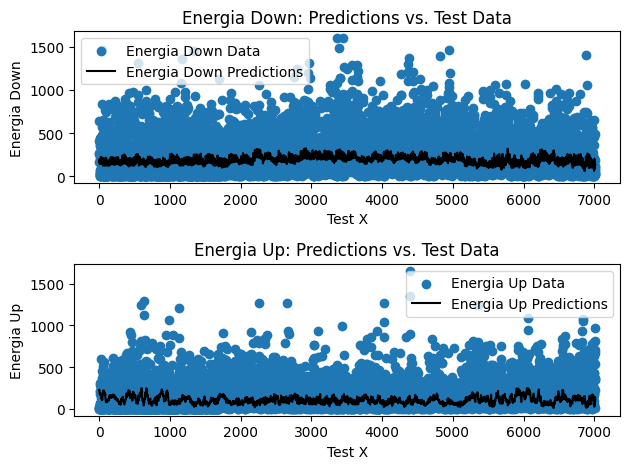

In [36]:
plot_pred_vs_test(np.arange(len(test_dataset_X)), test_dataset_Y.squeeze(), predictions)

In [37]:
def plot_percentage_diffs(predictions, test_dataset_Y):
    mse_dim1 = np.mean((predictions[:, 0] - test_dataset_Y.squeeze()[:,0]) ** 2)
    rmse_dim1 = np.sqrt(mse_dim1)

    mse_dim2 = np.mean((predictions[:, 1] - test_dataset_Y.squeeze()[:,1]) ** 2)
    rmse_dim2 = np.sqrt(mse_dim2)

    mse = np.mean((predictions - test_dataset_Y.squeeze()) ** 2)
    rmse = np.sqrt(mse)

    
    print("The root mean squared erros in Energia down is",rmse_dim1)
    print("The root mean squared erros in Energia up is",rmse_dim2)
    
    print("The root mean squared erros in both is",rmse)
    
    
    differences_dim1_percentage = (predictions[:, 0] - test_dataset_Y.squeeze()[:,0])/predictions[:, 0]
    differences_dim2_percentage = (predictions[:, 1] - test_dataset_Y.squeeze()[:,0])/predictions[:, 1]

    differences_percentage = (predictions - test_dataset_Y.squeeze())/predictions

    plt.figure(figsize=(10, 6))

    # Plot differences for dimension 1
    plt.subplot(3, 1, 1)
    plt.plot(range(len(differences_dim1_percentage)), differences_dim1_percentage, 'b.')
    plt.xlabel('Row Index')
    plt.ylabel('Difference')
    plt.title('Energia down: Individual Differences percentage')

    # Plot differences for dimension 2
    plt.subplot(3, 1, 2)
    plt.plot(range(len(differences_dim2_percentage)), differences_dim2_percentage, 'g.')
    plt.xlabel('Row Index')
    plt.ylabel('Difference')
    plt.title('Energia up: Individual Differences percentage')
    
    plt.subplot(3, 1, 3)
    plt.plot(range(len(differences_percentage)), differences_percentage, 'g.')
    plt.xlabel('Row Index')
    plt.ylabel('Difference')
    plt.title('Both: Individual Differences percentage')

    plt.tight_layout()
    plt.show()

The root mean squared erros in Energia down is 229.92639683486803
The root mean squared erros in Energia up is 174.92008512943508
The root mean squared erros in both is 204.28311744140046


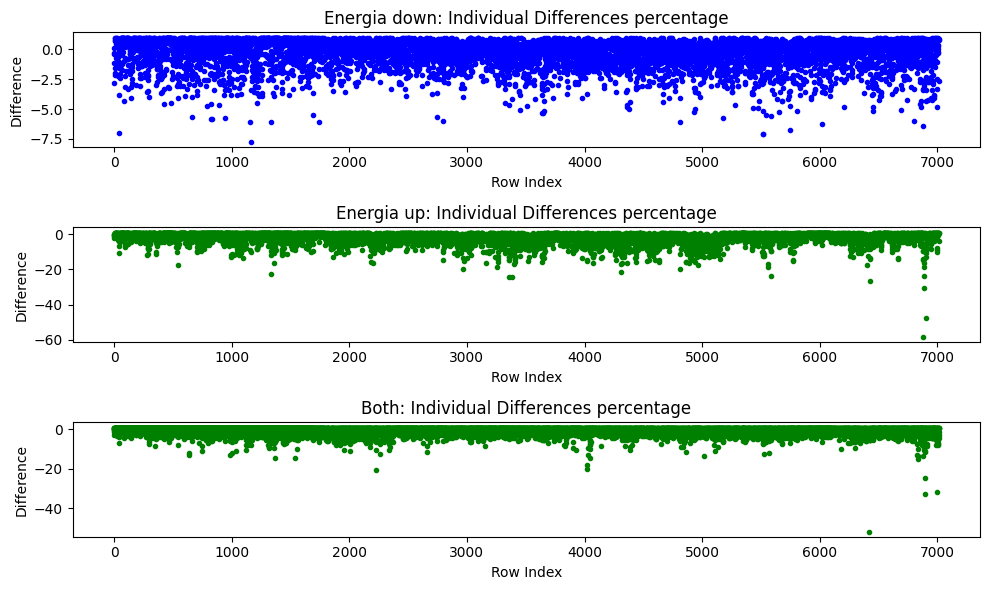

In [38]:
plot_percentage_diffs(predictions, test_dataset_Y)

In [39]:
# Multiple dense layers



input_layer = Input((7,))
normed = Normalization()(input_layer)
normed = Dense(168, activation="linear")(normed)
dropped1 = Dropout(0.5)(normed)

normed = Dense(64, activation="linear")(dropped1)
dropped1 = Dropout(0.5)(normed)

output = Dense(2, activation="linear")(dropped1)

model_dense2 = Model(inputs=input_layer, outputs=output)


In [40]:
model_dense2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 normalization_1 (Normaliza  (None, 7)                 15        
 tion)                                                           
                                                                 
 dense_1 (Dense)             (None, 168)               1344      
                                                                 
 dropout (Dropout)           (None, 168)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                10816     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                           

In [41]:
model_dense2.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)
model_dense2.fit(train_dataset_X.squeeze(), train_dataset_Y.squeeze(), epochs=17)

Epoch 1/17
877/877 [==============================] - 2s 1ms/step - loss: 1479.5537 - root_mean_squared_error: 1478.8552
Epoch 2/17
877/877 [==============================] - 1s 2ms/step - loss: 219.3901 - root_mean_squared_error: 219.3934
Epoch 3/17
877/877 [==============================] - 1s 1ms/step - loss: 192.2586 - root_mean_squared_error: 192.2297
Epoch 4/17
877/877 [==============================] - 1s 1ms/step - loss: 190.5340 - root_mean_squared_error: 190.5202
Epoch 5/17
877/877 [==============================] - 1s 1ms/step - loss: 190.6134 - root_mean_squared_error: 190.6026
Epoch 6/17
877/877 [==============================] - 1s 1ms/step - loss: 190.9276 - root_mean_squared_error: 190.9643
Epoch 7/17
877/877 [==============================] - 2s 2ms/step - loss: 191.3702 - root_mean_squared_error: 191.4287
Epoch 8/17
877/877 [==============================] - 1s 1ms/step - loss: 191.4885 - root_mean_squared_error: 191.4803
Epoch 9/17
877/877 [==========================

In [42]:
predictions = model_dense2.predict(test_dataset_X.squeeze())

220/220 [==============================] - 0s 612us/step


In [43]:
model_dense2.evaluate(test_dataset_X.squeeze(), test_dataset_Y.squeeze())

220/220 [==============================] - 0s 628us/step - loss: 207.5759 - root_mean_squared_error: 208.0427


[207.57586669921875, 208.0426788330078]

In [44]:
test_dataset["dense2 Energia Down"] = None
test_dataset["dense2 Energia Up"] = None

test_dataset.loc[test_index+X_timeseries, "dense2 Energia Down"] = predictions[:,0]
test_dataset.loc[test_index+X_timeseries, "dense2 Energia Up"] = predictions[:,1]


(7012,)
(7012, 2)


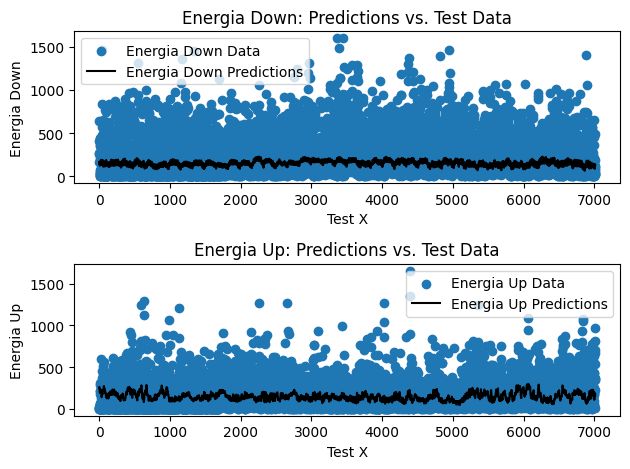

In [45]:
plot_pred_vs_test(np.arange(len(test_dataset_X)), test_dataset_Y.squeeze(), predictions)

The root mean squared erros in Energia down is 249.4667730353496
The root mean squared erros in Energia up is 166.73062363420968
The root mean squared erros in both is 212.17065266681334


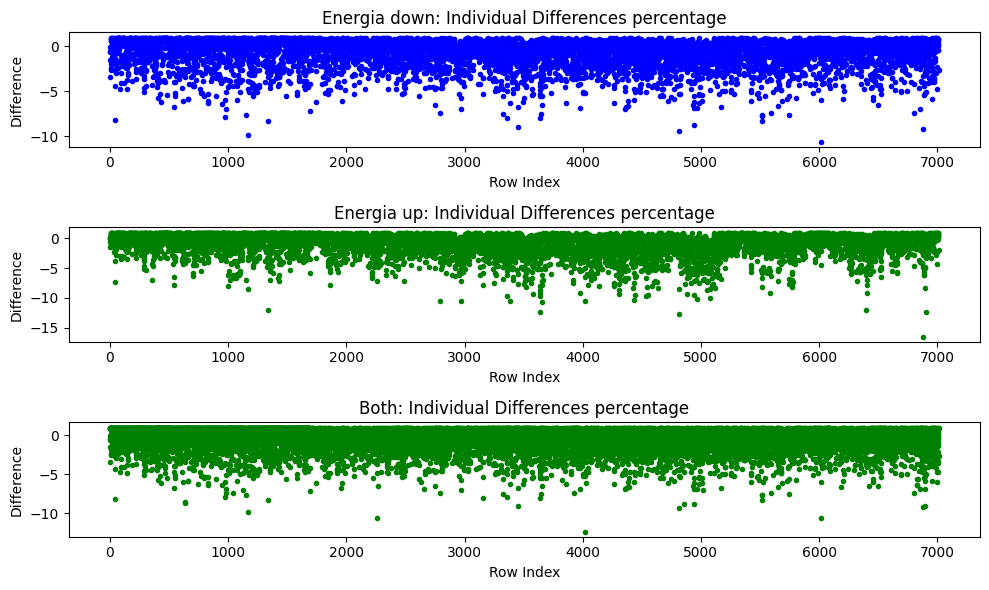

In [46]:
plot_percentage_diffs(predictions, test_dataset_Y)

In [47]:
uri = "model_dense2.keras"
model_dense2.save(uri)


In [48]:
test_dataset[test_dataset["dense2 Energia Down"]==test_dataset["dense2 Energia Down"]]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
28049         638.9         2.3                  15822.0            62.7   
28050         410.3         0.5                  15684.0             0.0   
28051         269.4        12.7                  15627.0             0.0   
28052         252.8        14.7                  15627.0             0.0   
28053         161.0        21.4                  15427.0             0.0   
...             ...         ...                      ...             ...   
35056         113.2       374.4                  10588.0             0.0   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
28049              31533.0           35048.3               -4162.2   
28050              32765.0           36029.4               -4060.0   
28051              31676.0           35060.3               -4080.5   
28052              28887.0           32296.1               -4217.2   
28053              26119.0           29388.5               -3884.8   
...                    ...               ...                   ...   
35056              25526.3           24829.1                -496.0   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
28049         17796.2         169.3         169.068665       224.169327   
28050         17852.7         161.4         189.304382       229.302521   
28051         17468.7         116.0         198.458633       229.816238   
28052         16997.5          37.9         192.185455       224.553116   
28053         16607.7           5.5         175.416122        207.90744   
...               ...           ...                ...              ...   
35056         11444.4         301.1         118.647682       125.891365   
35057         11529.9          58.5         152.996567       128.969223   
35058         11457.4           8.6         154.705734       131.108673   
35059          9346.3           7.2          145.27063       141.688629   
35060          9190.6           6.7         132.074951          95.9356   

      dense2 Energia Down dense2 Energia Up  
28049          146.358627        256.676392  
28050          164.633789        259.639984  
28051          171.753586         262.97702  
28052          167.266663        255.740402  
28053          152.629929         239.88768  
...                   ...               ...  
35056          114.672646        173.734756  
35057          136.546921         180.03862  
35058          140.205887        184.945786  
35059          134.319763        186.180435  
35060          133.253159         161.47261  

[7012 rows x 13 columns]

In [49]:
35064/24 # this is the number of days in the dataset

1461.0

In [50]:
7*24

168

In [51]:
len(dataset)

35062

In [52]:
# One week to get one day

X_timeseries = 168
Y_timeseries = 24

train_dataset_X, train_dataset_Y, test_dataset_X, test_dataset_Y, index_test = get_dataset(dataset, 
                                                                               time_moving_window_size_X=X_timeseries,
                                                                              time_moving_window_size_Y=Y_timeseries,
                                                                              index_train=index_train)

In [53]:
## Simple timeries conv model



import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import (
    BatchNormalization,
    Normalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling1D,
    concatenate,
)


from keras.models import Model

time_length = X_timeseries #hours

# channels last -> channels sao as dimensoes diff
input_layer_saphe = (time_length, 7)
filters = 128
dropout_value = 0.25
kernel_size = 24
input_layer = Input(input_layer_saphe)
normed = BatchNormalization()(input_layer)





# first feature extractor
conv1 = Conv1D(
    filters=64,
    kernel_size=kernel_size,
    activation="linear",
)(normed)

normed1 = BatchNormalization()(conv1)
dropped1 = Dropout(dropout_value)(normed1)
convd1 = Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    activation="linear",
)(dropped1)
normed11 = BatchNormalization()(convd1)
pool1 = MaxPooling1D(pool_size=2)(normed11)
flat1 = Flatten()(pool1)

min_value_inshape = min([f for f in normed.shape if f is not None])
values_consider = []

for i in range(min_value_inshape):
    step = min_value_inshape - i + 1
    if step >= i:
        values_consider.append(i)

kernel_size_second = max(values_consider)

# second feature extractor
conv2 = Conv1D(
    filters=filters,
    kernel_size=kernel_size_second,
    activation='linear',
)(normed)
normed2 = BatchNormalization()(conv2)

dropped2 = Dropout(dropout_value)(normed2)
convd2 = Conv1D(
    filters=filters,
    kernel_size=kernel_size_second,
    activation="linear",
)(dropped2)
normed22 = BatchNormalization()(convd2)
pool_zi = min([f for f in normed22.shape if f is not None])
pool_zi = min([pool_zi, 2])
pool2 = MaxPooling1D(pool_size=pool_zi)(normed22)
flat2 = Flatten()(pool2)
# merge feature extractors
merge = concatenate([flat1, flat2])
dropped = Dropout(dropout_value)(merge)

# interpretation layer
hidden1 = Dense(100, activation='linear')(dropped)
normed3 = Normalization()(hidden1)
# prediction output
# Reshape output to (24, 2)
output = Dense(24 * 2, activation="linear")(normed3)
reshaped_output = tf.reshape(output, (-1, Y_timeseries, 2))











model = Model(inputs=input_layer, outputs=reshaped_output)


In [54]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 168, 7)]             0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 168, 7)               28        ['input_3[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d (Conv1D)             (None, 145, 64)              10816     ['batch_normalization[0][0]'] 
                                                                                                  
 conv1d_2 (Conv1D)           (None, 165, 128)             3712      ['batch_normalization[0]

In [55]:
model.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)

In [56]:
model.fit(train_dataset_X, train_dataset_Y, epochs=10)

Epoch 1/10
872/872 [==============================] - 69s 78ms/step - loss: 184.2682 - root_mean_squared_error: 184.2664
Epoch 2/10
872/872 [==============================] - 70s 80ms/step - loss: 182.0517 - root_mean_squared_error: 182.0509
Epoch 3/10
872/872 [==============================] - 72s 83ms/step - loss: 181.2014 - root_mean_squared_error: 181.2038
Epoch 4/10
872/872 [==============================] - 72s 82ms/step - loss: 180.5725 - root_mean_squared_error: 180.5715
Epoch 5/10
872/872 [==============================] - 67s 77ms/step - loss: 180.0028 - root_mean_squared_error: 180.0032
Epoch 6/10
872/872 [==============================] - 66s 75ms/step - loss: 179.6257 - root_mean_squared_error: 179.6203
Epoch 7/10
872/872 [==============================] - 71s 82ms/step - loss: 179.3216 - root_mean_squared_error: 179.3189
Epoch 8/10
872/872 [==============================] - 75s 85ms/step - loss: 179.0631 - root_mean_squared_error: 179.0629
Epoch 9/10
872/872 [============

In [57]:
uri = "model_conv1D.keras"
model.save(uri)


In [58]:
model.history.history

{'loss': [184.26817321777344,
  182.0517120361328,
  181.201416015625,
  180.57247924804688,
  180.00277709960938,
  179.6256561279297,
  179.32159423828125,
  179.06309509277344,
  178.82431030273438,
  178.62266540527344],
 'root_mean_squared_error': [184.26644897460938,
  182.05087280273438,
  181.20376586914062,
  180.57151794433594,
  180.0032196044922,
  179.6202850341797,
  179.3188934326172,
  179.06289672851562,
  178.8223419189453,
  178.622802734375]}

In [59]:
predictions = model.predict(test_dataset_X)

218/218 [==============================] - 3s 15ms/step


In [60]:
predictions.shape

(6974, 24, 2)

In [61]:
def moving_mean_predictions(predictions):
    flatten_preds = []
    size = len(predictions)


    for i in range(size):
        row = predictions[i]
        init = np.full((i, 2), np.nan)
        end_len = size - i
        if end_len<0:
            end = np.full((0, 2), np.nan)
        else:
            end = np.full((end_len, 2), np.nan)
        fi_row = np.concatenate([init, row, end])
        flatten_preds.append(fi_row)
    flatten_preds = np.array(flatten_preds)
    moving_mean = np.nanmean(flatten_preds, axis=0)
    mask = np.isnan(moving_mean).any(axis=1)
    return moving_mean[~mask]

In [62]:
predictions_mean = moving_mean_predictions(predictions)
test_dataset_Y_mean = moving_mean_predictions(test_dataset_Y)

/tmp/ipykernel_37292/2155408381.py:17: RuntimeWarning: Mean of empty slice
  moving_mean = np.nanmean(flatten_preds, axis=0)


In [63]:
test_dataset_Y_mean

array([[350.2,   0.9],
       [ 68.9,  64.9],
       [ 42.9, 304.8],
       ...,
       [ 35. , 673.5],
       [ 21.1, 344.9],
       [486. ,   3.9]])

In [64]:
test_dataset[test_dataset["Energia Down"]==350.2]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
13052         350.2         4.4                   3040.0             0.0   
21009         350.2         3.7                   4153.0          4673.5   
28064         350.2         0.9                  12454.0          3746.7   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
13052              25388.0           22788.8                 851.7   
21009              30614.0           28508.0                1756.0   
28064              31585.0           35757.5               -4621.0   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
13052          4636.8          42.0               None             None   
21009          5309.7        6907.6               None             None   
28064         12952.7        4489.9         203.744019       180.719315   

      dense2 Energia Down dense2 Energia Up  
13052                None              None  
21009                None              None  
28064          163.767471        221.509659

In [65]:
test_index = test_dataset.loc[28064:35060].index

In [66]:
test_dataset.loc[28064:35060]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
28064         350.2         0.9                  12454.0          3746.7   
28065          68.9        64.9                  12250.0          4142.5   
28066          42.9       304.8                  12326.0          3994.0   
28067           7.7       213.1                  12536.0          3651.4   
28068         149.7        11.1                  12697.0          3561.4   
...             ...         ...                      ...             ...   
35056         113.2       374.4                  10588.0             0.0   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
28064              31585.0           35757.5               -4621.0   
28065              31480.0           35473.3               -4516.4   
28066              31437.0           36056.6               -4894.0   
28067              31310.0           35732.6               -4823.0   
28068              30674.0           35384.6               -4986.8   
...                    ...               ...                   ...   
35056              25526.3           24829.1                -496.0   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
28064         12952.7        4489.9         203.744019       180.719315   
28065         12946.1        5268.4         208.630508       170.479782   
28066         12918.2        5657.2          200.35347        168.18988   
28067         13178.8        5817.5         190.937729        176.85434   
28068         13263.7        5583.5         179.580032       177.640564   
...               ...           ...                ...              ...   
35056         11444.4         301.1         118.647682       125.891365   
35057         11529.9          58.5         152.996567       128.969223   
35058         11457.4           8.6         154.705734       131.108673   
35059          9346.3           7.2          145.27063       141.688629   
35060          9190.6           6.7         132.074951          95.9356   

      dense2 Energia Down dense2 Energia Up  
28064          163.767471        221.509659  
28065          159.668777        219.905991  
28066          151.516785        223.893951  
28067          147.796432        228.855682  
28068          142.290848        233.492905  
...                   ...               ...  
35056          114.672646        173.734756  
35057          136.546921         180.03862  
35058          140.205887        184.945786  
35059          134.319763        186.180435  
35060          133.253159         161.47261  

[6997 rows x 13 columns]

In [67]:
test_dataset_X

array([[[ 7.69200e+03,  4.38620e+03,  3.29530e+04, ...,  4.28700e+02,
          7.92360e+03,  4.66730e+03],
        [ 7.84000e+03,  5.84490e+03,  3.26830e+04, ...,  7.19700e+02,
          7.83940e+03,  5.97890e+03],
        [ 7.95200e+03,  6.10490e+03,  3.26190e+04, ...,  3.03800e+02,
          7.78560e+03,  6.64740e+03],
        ...,
        [ 1.34570e+04,  1.33500e+02,  2.85520e+04, ..., -2.88350e+03,
          1.36476e+04,  1.02100e+02],
        [ 1.30750e+04,  1.03880e+03,  3.05200e+04, ..., -3.20690e+03,
          1.35422e+04,  1.22070e+03],
        [ 1.26570e+04,  2.61390e+03,  3.13570e+04, ..., -4.11120e+03,
          1.32563e+04,  3.17380e+03]],

       [[ 7.84000e+03,  5.84490e+03,  3.26830e+04, ...,  7.19700e+02,
          7.83940e+03,  5.97890e+03],
        [ 7.95200e+03,  6.10490e+03,  3.26190e+04, ...,  3.03800e+02,
          7.78560e+03,  6.64740e+03],
        [ 7.45200e+03,  6.48980e+03,  3.25280e+04, ...,  1.06890e+03,
          7.51620e+03,  6.82720e+03],
        ...,


In [68]:
test_dataset_Y_mean.shape

(6997, 2)

In [69]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
0              4326.8           7.1               None             None   
1              4213.9           7.1               None             None   
2              4059.7           7.1               None             None   
3              3921.6           7.1               None             None   
4              3902.3          14.1               None             None   
...               ...           ...                ...              ...   
35057         11529.9          58.5         152.996567       128.969223   
35058         11457.4           8.6         154.705734       131.108673   
35059          9346.3           7.2          145.27063       141.688629   
35060          9190.6           6.7         132.074951          95.9356   
35061          8314.2           6.6               None             None   

      dense2 Energia Down dense2 Energia Up  
0                    None              None  
1                    None              None  
2                    None              None  
3                    None              None  
4                    None              None  
...                   ...               ...  
35057          136.546921         180.03862  
35058          140.205887        184.945786  
35059          134.319763        186.180435  
35060          133.253159         161.47261  
35061                None              None  

[35062 rows x 13 columns]

In [70]:
Y_timeseries

24

In [71]:
test_dataset_Y_mean

array([[350.2,   0.9],
       [ 68.9,  64.9],
       [ 42.9, 304.8],
       ...,
       [ 35. , 673.5],
       [ 21.1, 344.9],
       [486. ,   3.9]])

In [72]:
test_dataset_Y_mean[-4]

array([186.4, 816.6])

In [73]:
test_index + 16

Index([28080, 28081, 28082, 28083, 28084, 28085, 28086, 28087, 28088, 28089,
       ...
       35067, 35068, 35069, 35070, 35071, 35072, 35073, 35074, 35075, 35076],
      dtype='int64', length=6997)

In [74]:
len(test_index)

6997

In [75]:
len(predictions_mean)

6997

In [76]:
test_dataset["conv Energia Down"] = None
test_dataset["conv Energia Up"] = None

test_dataset.loc[test_index, "conv Energia Down"] = predictions_mean[:,0]
test_dataset.loc[test_index, "conv Energia Up"] = predictions_mean[:,1]


In [77]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
0              4326.8           7.1               None             None   
1              4213.9           7.1               None             None   
2              4059.7           7.1               None             None   
3              3921.6           7.1               None             None   
4              3902.3          14.1               None             None   
...               ...           ...                ...              ...   
35057         11529.9          58.5         152.996567       128.969223   
35058         11457.4           8.6         154.705734       131.108673   
35059          9346.3           7.2          145.27063       141.688629   
35060          9190.6           6.7         132.074951          95.9356   
35061          8314.2           6.6               None             None   

      dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  
0                    None              None              None            None  
1                    None              None              None            None  
2                    None              None              None            None  
3                    None              None              None            None  
4                    None              None              None            None  
...                   ...               ...               ...             ...  
35057          136.546921         180.03862        271.606491      108.614857  
35058          140.205887        184.945786        188.616709      161.084264  
35059          134.319763        186.180435        105.936012      209.151184  
35060          133.253159         161.47261         98.276787      209.367203  
35061                None              None              None            None  

[35062 rows x 15 columns]

(6997,)
(6997, 2)


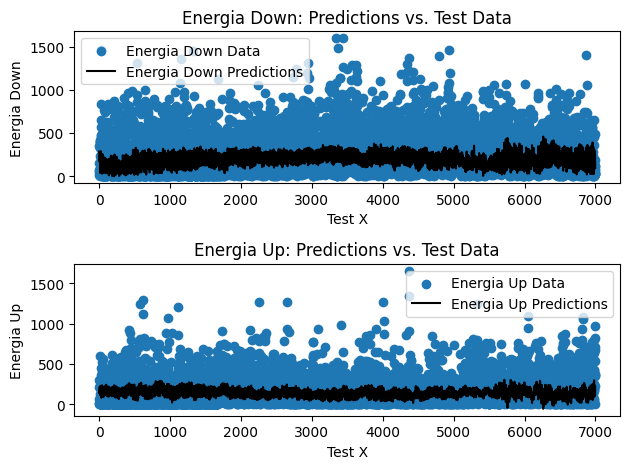

In [78]:
plot_pred_vs_test(np.arange(len(test_dataset_Y_mean)), test_dataset_Y_mean.squeeze(), predictions_mean)

The root mean squared erros in Energia down is 227.58697101175213
The root mean squared erros in Energia up is 170.28056965470472
The root mean squared erros in both is 200.98669331106828


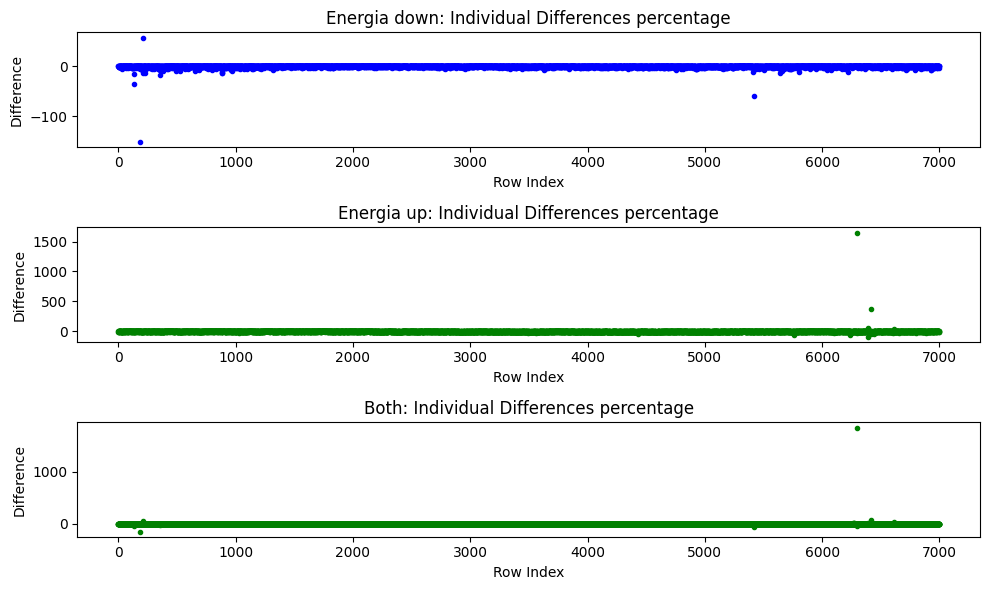

In [79]:
plot_percentage_diffs(predictions_mean, test_dataset_Y_mean)

In [80]:

end_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[-1][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[-1][0][4])].index.item()
start_ind = test_dataset[(test_dataset["Day-ahead Forecast Wind"]==test_dataset_X[0][0][0])&(test_dataset["DA Tie Lines Balance"]==test_dataset_X[0][0][4])].index.item()

In [81]:
test_dataset[start_ind:end_ind]

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
27896          14.5       248.7                   7692.0          4386.2   
27897           7.6       166.5                   7840.0          5844.9   
27898         184.1       119.8                   7952.0          6104.9   
27899         255.6        23.7                   7452.0          6489.8   
27900         660.3        28.3                   6970.0          6658.4   
...             ...         ...                      ...             ...   
34864         259.6        21.6                   9666.0             0.0   
34865         459.1        13.7                   9659.5             0.0   
34866         201.0       138.8                   9580.0             0.0   
34867         129.1       252.9                   9319.5             0.0   
34868         145.4       170.7                   8859.3             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
27896              32953.0           30026.5                 428.7   
27897              32683.0           30367.9                 719.7   
27898              32619.0           31092.3                 303.8   
27899              32528.0           30749.7                1068.9   
27900              32104.0           30222.8                1035.1   
...                    ...               ...                   ...   
34864              29885.3           29403.9               -2045.4   
34865              30105.0           29508.3               -1836.7   
34866              30311.8           29226.4               -1633.0   
34867              29684.5           28853.1               -1915.8   
34868              27261.0           27070.1               -2097.3   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
27896          7923.6        4667.3               None             None   
27897          7839.4        5978.9               None             None   
27898          7785.6        6647.4               None             None   
27899          7516.2        6827.2               None             None   
27900          7379.4        6869.1               None             None   
...               ...           ...                ...              ...   
34864         10821.4          71.6         185.182205       113.536575   
34865         10689.8          38.7         217.056808       101.875221   
34866         10388.5          36.9         218.319733       102.344902   
34867         10327.0           7.5         222.932312        89.913338   
34868         10086.4           7.1         220.388199        89.427628   

      dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  
27896                None              None              None            None  
27897                None              None              None            None  
27898                None              None              None            None  
27899                None              None              None            None  
27900                None              None              None            None  
...                   ...               ...               ...             ...  
34864          155.098801        175.153397        326.913985       17.409303  
34865          174.974411         164.98436        357.018397       17.836814  
34866          177.130463        165.057404        269.459358       91.147764  
34867          179.941116        159.106293        181.850885      149.959608  
34868          176.193115        156.244064        174.891717       151.44594  

[6973 rows x 15 columns]

In [82]:
# RNN try

from tensorflow.keras.layers import (
    LSTM,
    BatchNormalization,
    Bidirectional,
    Dense,
    Dropout,
    MaxPooling1D,
)

# channels last -> channels sao as dimensoes diff
input_layer_saphe = (time_length, 7)
filters = 128
dropout_value = 0.25
kernel_size = 24
input_layer = Input(input_layer_saphe)
normed = BatchNormalization()(input_layer)


lstm_units = (120, 80)
pool_size = 3


x = BatchNormalization()(normed)
x = LSTM(
    lstm_units[0],
    return_sequences=True,
    dropout=dropout_value,
    recurrent_dropout=dropout_value,
)(x)
x = MaxPooling1D(pool_size=pool_size)(x)
x = BatchNormalization()(x)
x = Bidirectional(
    LSTM(
        lstm_units[1],
        dropout=dropout_value,
        recurrent_dropout=dropout_value,
    )
)(x)
x = BatchNormalization()(x)
x = Dropout(dropout_value)(x)
x = Dense(120, activation="linear")(x)
x = BatchNormalization()(x)
x = Dense(2, activation="linear")(x)
x = Dense(24 * 2, activation="linear")(x)
x = tf.reshape(x, (-1, 24, 2))


model_rnn = Model(inputs=input_layer, outputs=x)


In [83]:
model_rnn.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 168, 7)]          0         
                                                                 
 batch_normalization_5 (Bat  (None, 168, 7)            28        
 chNormalization)                                                
                                                                 
 batch_normalization_6 (Bat  (None, 168, 7)            28        
 chNormalization)                                                
                                                                 
 lstm (LSTM)                 (None, 168, 120)          61440     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 56, 120)           0         
 g1D)                                                            
                                                           

In [84]:
model_rnn.compile(optimizer='adam',loss=root_mean_squared_error, metrics=root_mean_squared_error)

In [85]:
model_rnn.fit(train_dataset_X, train_dataset_Y, epochs=5)

Epoch 1/5
872/872 [==============================] - 136s 150ms/step - loss: 215.4097 - root_mean_squared_error: 215.4005
Epoch 2/5
872/872 [==============================] - 130s 149ms/step - loss: 185.8993 - root_mean_squared_error: 185.9011
Epoch 3/5
872/872 [==============================] - 142s 163ms/step - loss: 183.7627 - root_mean_squared_error: 183.7620
Epoch 4/5
872/872 [==============================] - 138s 158ms/step - loss: 182.8278 - root_mean_squared_error: 182.8313
Epoch 5/5
872/872 [==============================] - 148s 170ms/step - loss: 182.2093 - root_mean_squared_error: 182.2120


In [86]:
uri = "model_rnn.keras"
model_rnn.save(uri)


In [87]:
predictions = model_rnn.predict(test_dataset_X)

218/218 [==============================] - 8s 36ms/step


In [88]:
predictions_mean = moving_mean_predictions(predictions)
test_dataset_Y_mean = moving_mean_predictions(test_dataset_Y)

/tmp/ipykernel_37292/2155408381.py:17: RuntimeWarning: Mean of empty slice
  moving_mean = np.nanmean(flatten_preds, axis=0)


In [89]:
test_dataset["rnn Energia Down"] = None
test_dataset["rnn Energia Up"] = None

test_dataset.loc[test_index, "rnn Energia Down"] = predictions_mean[:,0]
test_dataset.loc[test_index, "rnn Energia Up"] = predictions_mean[:,1]


In [90]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
0              4326.8           7.1               None             None   
1              4213.9           7.1               None             None   
2              4059.7           7.1               None             None   
3              3921.6           7.1               None             None   
4              3902.3          14.1               None             None   
...               ...           ...                ...              ...   
35057         11529.9          58.5         152.996567       128.969223   
35058         11457.4           8.6         154.705734       131.108673   
35059          9346.3           7.2          145.27063       141.688629   
35060          9190.6           6.7         132.074951          95.9356   
35061          8314.2           6.6               None             None   

      dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  \
0                    None              None              None            None   
1                    None              None              None            None   
2                    None              None              None            None   
3                    None              None              None            None   
4                    None              None              None            None   
...                   ...               ...               ...             ...   
35057          136.546921         180.03862        271.606491      108.614857   
35058          140.205887        184.945786        188.616709      161.084264   
35059          134.319763        186.180435        105.936012      209.151184   
35060          133.253159         161.47261         98.276787      209.367203   
35061                None              None              None            None   

      rnn Energia Down rnn Energia Up  
0                 None           None  
1                 None           None  
2                 None           None  
3                 None           None  
4                 None           None  
...                ...            ...  
35057       136.889896     199.660069  
35058       140.283218     196.372798  
35059       140.839

(6997,)
(6997, 2)


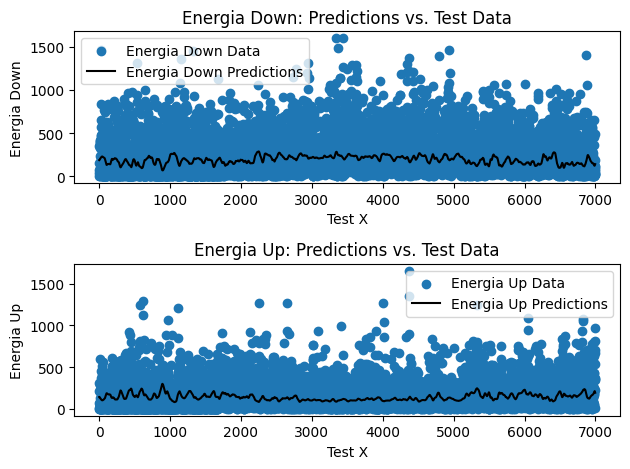

In [91]:
plot_pred_vs_test(np.arange(len(test_dataset_Y_mean)), test_dataset_Y_mean.squeeze(), predictions_mean)

The root mean squared erros in Energia down is 233.13520168727607
The root mean squared erros in Energia up is 167.8331074622458
The root mean squared erros in both is 203.12554520074605


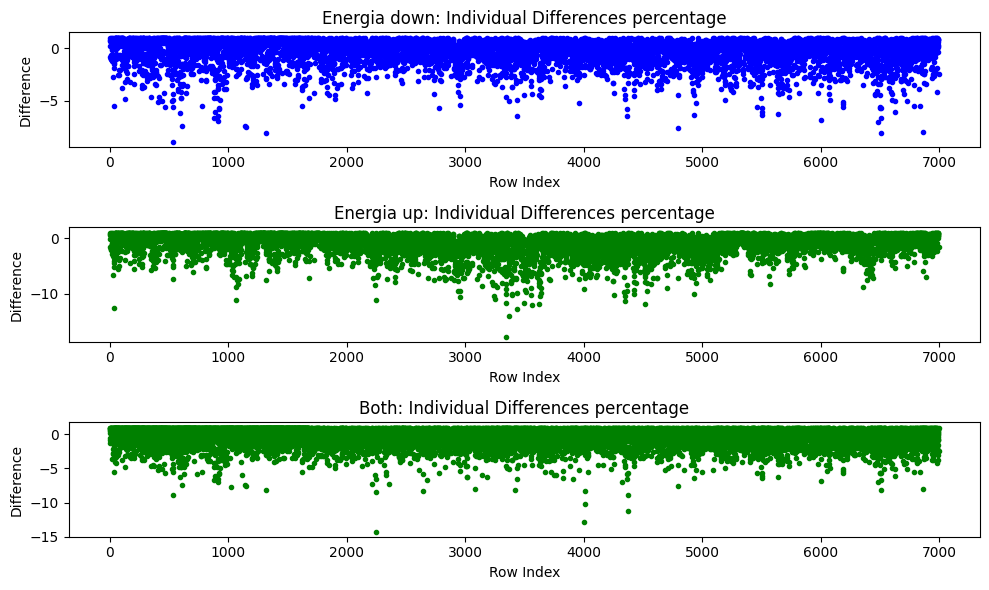

In [92]:
plot_percentage_diffs(predictions_mean, test_dataset_Y_mean)

In [97]:
test_dataset

Energia Down  Energia Up  Day-ahead Forecast Wind  DA Forecast PV  \
0              83.7       116.9                   3715.0             0.0   
1              11.6       348.1                   3748.0             0.0   
2              15.3       286.9                   3545.0             0.0   
3              36.6       398.4                   3407.0             0.0   
4              22.4       280.9                   3321.0             0.0   
...             ...         ...                      ...             ...   
35057         186.4       816.6                  10615.5             0.0   
35058          35.0       673.5                  10477.8             0.0   
35059          21.1       344.9                  10446.8             0.0   
35060         486.0         3.9                  10402.5             0.0   
35061         352.4        15.9                  10305.0             0.0   

       DA Forecast Consumo  DAToda a Geração  DA Tie Lines Balance  \
0                  21808.0           18365.7                1524.9   
1                  20635.0           17396.3                1336.4   
2                  19824.0           17080.8                1158.3   
3                  19544.0           17125.4                1114.3   
4                  19803.0           17163.7                1323.6   
...                    ...               ...                   ...   
35057              26203.0           24536.6                 579.2   
35058              25256.5           24128.0                 483.6   
35059              24142.3           20040.7                3398.3   
35060              21761.5           19618.6                1756.2   
35061              20590.3           16847.4                3270.8   

       DA Traded Wind  DA Traded PV dense Energia Down dense Energia Up  \
0              4326.8           7.1               None             None   
1              4213.9           7.1               None             None   
2              4059.7           7.1               None             None   
3              3921.6           7.1               None             None   
4              3902.3          14.1               None             None   
...               ...           ...                ...              ...   
35057         11529.9          58.5         152.996567       128.969223   
35058         11457.4           8.6         154.705734       131.108673   
35059          9346.3           7.2          145.27063       141.688629   
35060          9190.6           6.7         132.074951          95.9356   
35061          8314.2           6.6               None             None   

      dense2 Energia Down dense2 Energia Up conv Energia Down conv Energia Up  \
0                    None              None              None            None   
1                    None              None              None            None   
2                    None              None              None            None   
3                    None              None              None            None   
4                    None              None              None            None   
...                   ...               ...               ...             ...   
35057          136.546921         180.03862        271.606491      108.614857   
35058          140.205887        184.945786        188.616709      161.084264   
35059          134.319763        186.180435        105.936012      209.151184   
35060          133.253159         161.47261         98.276787      209.367203   
35061                None              None              None            None   

      rnn Energia Down rnn Energia Up  
0                 None           None  
1                 None           None  
2                 None           None  
3                 None           None  
4                 None           None  
...                ...            ...  
35057       136.889896     199.660069  
35058       140.283218     196.372798  
35059       140.839

In [107]:
down_cols = [f for f in test_dataset.columns if "Energia Down" in f]
up_cols = [f for f in test_dataset.columns if "Energia Up" in f]

down_dataset = test_dataset[down_cols].dropna().copy()
up_dataset = test_dataset[up_cols].dropna().copy()

<Axes: >

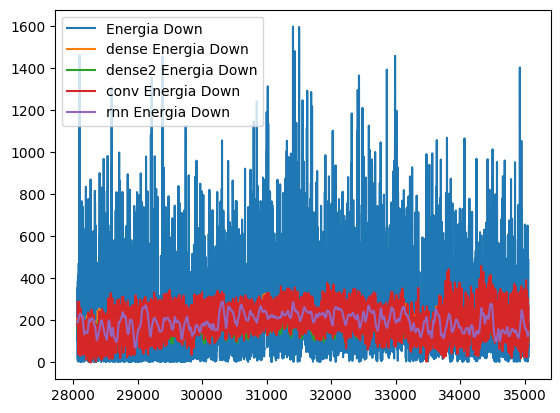

In [108]:
down_dataset.plot()

<Axes: >

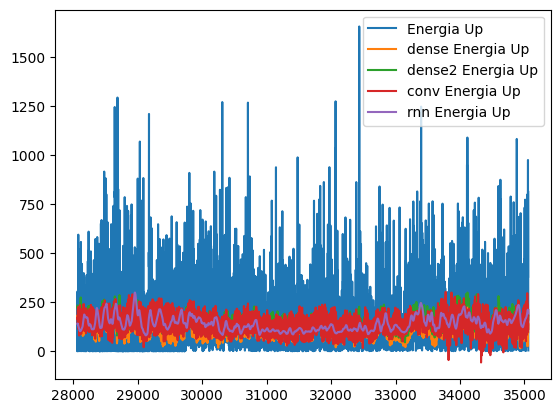

In [109]:
up_dataset.dropna().plot()

In [115]:
cols_use = [f for f in up_dataset.columns if f != "Energia Up"]

for i in cols_use:
    new_name = f"{i} percentage"
    up_dataset[new_name] = (up_dataset["Energia Up"] - up_dataset[i])/up_dataset["Energia Up"]
    
cols_use = [f for f in down_dataset.columns if f != "Energia Down"]

for i in cols_use:
    new_name = f"{i} percentage"
    down_dataset[new_name] = (down_dataset["Energia Down"] - down_dataset[i])/down_dataset["Energia Down"]

ZeroDivisionError: float division by zero

In [118]:
down_dataset["Energia Down"]==0

28064    False
28065    False
28066    False
28067    False
28068    False
         ...  
35056    False
35057    False
35058    False
35059    False
35060    False
Name: Energia Down, Length: 6997, dtype: bool